In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gco

K1 = np.array(
    [[1221.2270770, 0.0000000, 479.5000000], [0.0000000, 1221.2270770, 269.5000000], [0.0000000, 0.0000000, 1.0000000]])
R1 = np.array([[1.0000000000, 0.0000000000, 0.0000000000], [0.0000000000, 1.0000000000, 0.0000000000],
               [0.0000000000, 0.0000000000, 1.0000000000]])
T1 = np.array([[0.0000000000], [0.0000000000], [0.0000000000]])

K2 = np.array(
    [[1221.2270770, 0.0000000, 479.5000000], [0.0000000, 1221.2270770, 269.5000000], [0.0000000, 0.0000000, 1.0000000]])
R2 = np.array([[0.9998813487, 0.0148994942, 0.0039106989], [-0.0148907594, 0.9998865876, -0.0022532664],
               [-0.0039438279, 0.0021947658, 0.9999898146]])
T2 = np.array([[-9.9909793759], [0.2451742154], [0.1650832670]])

disparity = np.arange(0, 0.01, 0.01 / 65)

d_number = len(disparity)

img1 = cv.imread('data/test00.jpg')
img1 = img1[:, :, [2, 1, 0]]
img2 = cv.imread('data/test09.jpg')
img2 = img2[:, :, [2, 1, 0]]
H, W, D = img1.shape
print(img1.shape)
term2 = np.dot(np.dot(np.dot(K2, R2.T), R1), np.linalg.inv(K1))

term1 = np.dot(np.dot(K2, R2.T), (T1 - T2))
print(term2)
print(term1)
x_h_x = np.tile(np.arange(W)[:, np.newaxis], [1, H]).T.reshape(1, -1)
x_h_y = np.tile(np.arange(H)[:, np.newaxis], [1, W]).reshape(1, -1)

x_h = np.concatenate((x_h_x, x_h_y, np.ones(H * W).reshape(1, -1)), axis=0)
x_h_int = x_h.astype(int)
print(x_h.shape)
x_h_term = np.dot(term2, x_h)
print(x_h_term.shape)
x_h_1 = np.tile(x_h[:, :, np.newaxis], [1, 1, d_number])
for i in range(d_number):
    d_add = disparity[i] * term1
    # d_add_tile = np.tile(d_add[:,:],[1,H*W])
    x_h_1[:, :, i] = x_h_term + d_add

print(x_h_1.shape)
print(x_h_int)


(540, 960, 3)
[[ 1.00141684e+00 -1.57754771e-02 -1.24907567e+00]
 [ 1.57625060e-02  9.99389337e-01 -4.71598561e+00]
 [ 3.20227006e-06 -1.84508389e-06  9.98951576e-01]]
[[ 1.21449036e+04]
 [-1.51840163e+02]
 [-1.25457431e-01]]
(3, 518400)
(3, 518400)
(3, 518400, 65)
[[  0   1   2 ... 957 958 959]
 [  0   0   0 ... 539 539 539]
 [  1   1   1 ...   1   1   1]]


In [5]:
def dist(patch1, patch2):
    pixel_count = patch1.size
    _patch1 = patch1.flatten()
    _patch2 = patch2.flatten()
    value = 0.0
    for i in range(pixel_count):
        value += abs(float(_patch1[i]) - float(_patch2[i]))
    return value / pixel_count


d_number = len(disparity)
smooth = (1 - np.eye(d_number))
# smooth = 1-np.eye(d_number)
for i in range(d_number):
    for j in range(d_number):
        if i != j:
            smooth[i][j] = abs(i - j)
unary = np.zeros((H, W, d_number))
maxunary = 0

for i in range(H):
    for j in range(W):
        x, y = x_h_int[0:2, i * W + j]
        for k in range(d_number):
            x_1, y_1, z_1 = x_h_1[:, i * W + j, k]
            x_1 = int(x_1 / z_1)
            y_1 = int(y_1 / z_1)
            if 0 <= x_1 < W and 0 <= y_1 < H:
                unary[y, x, k] = dist(img1[y, x, :], img2[y_1, x_1, :])
                maxunary = max(unary[y, x, k], maxunary)

# unary = unary/maxunary

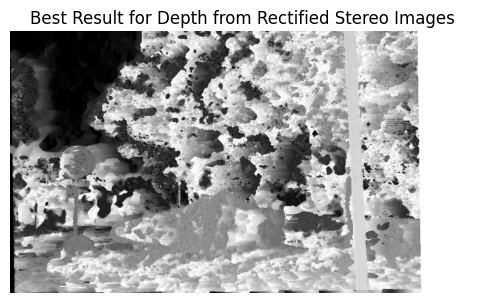

In [6]:
labels = gco.cut_grid_graph_simple(unary, smooth * 0.2, n_iter=-1, connect=8, algorithm='swap')
labels = labels.reshape(H, W)
plt.figure(num=1, dpi=100, figsize=(6, 6))
plt.imshow(labels, cmap='gray')
plt.title('Best Result for Depth from Rectified Stereo Images')
plt.axis("off")
plt.show()